In [1]:
#hide
#skip
import torch
torch.__version__
#!pip install -Uqq fastai

'1.6.0'

## This code was used as a reference for implementing Collaborative Filtering algorithm using the e-commerce dataset.

# Collaborative filtering

> Using the fastai library for collaborative filtering.

In [2]:
from fastai.tabular.all import *
from fastai.collab import *

## Training a model

In this notebook, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). 

In [3]:
ratings = pd.read_csv('ml-100k/u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
movies = pd.read_csv('ml-100k/u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [7]:
dls.show_batch()

,user,title,rating
0,14,Beautiful Girls (1996),3
1,548,Twelve Monkeys (1995),5
2,389,Air Force One (1997),3
3,907,It's a Wonderful Life (1946),4
4,636,Screamers (1995),5
5,393,"Prophecy, The (1995)",4
6,429,Bean (1997),3
7,249,Shallow Grave (1994),4
8,693,"Piano, The (1993)",2
9,716,Circle of Friends (1995),4


In [8]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [9]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.975831,0.930637,00:10
1,0.837065,0.864552,00:10
2,0.742641,0.826918,00:10
3,0.579480,0.815448,00:10
4,0.474087,0.816096,00:10


## Interpretation

The 1000 most rated movies for this:

In [10]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

The model has learned one bias per movie, a unique number independent of users.

In [11]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Compare those biases with the average ratings:

In [12]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [13]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3883),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3559), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3065),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2551), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2530), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2493), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2429), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2354), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2350), 'Stuart Saves His Family (1995)', 2.125),
 (tensor(-0.2267), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.2264), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2238), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2228), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2181), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (

Or the ones with the best bias:

In [14]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5441), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5386), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5381), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5283), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5199), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4985), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4979), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4844), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4803), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4735), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4589), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4568), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4416), 'North by Northwest (1959)', 4.284916201117318),
 (tensor(0.4393), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4324), 'Much Ado About Nothing (1993)', 4.0625)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [15]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [16]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [17]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [18]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1478), 'Casablanca (1942)'),
 (tensor(1.1091), 'Wrong Trousers, The (1993)'),
 (tensor(1.0965), 'Beautiful Thing (1996)'),
 (tensor(1.0871), 'Chinatown (1974)'),
 (tensor(1.0677), 'Third Man, The (1949)'),
 (tensor(1.0583), 'Ran (1985)'),
 (tensor(1.0558), 'When We Were Kings (1996)'),
 (tensor(1.0464), 'Fargo (1996)'),
 (tensor(1.0315), 'Godfather, The (1972)'),
 (tensor(1.0010), 'Lawrence of Arabia (1962)')]

And the worst:

In [19]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2342), 'Home Alone 3 (1997)'),
 (tensor(-1.1840), 'Bio-Dome (1996)'),
 (tensor(-1.1110), 'Leave It to Beaver (1997)'),
 (tensor(-1.1106), "McHale's Navy (1997)"),
 (tensor(-1.1004), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0843), 'Spice World (1997)'),
 (tensor(-1.0785), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0763), 'Grease 2 (1982)'),
 (tensor(-1.0689), 'Congo (1995)'),
 (tensor(-1.0611), 'Jungle2Jungle (1997)')]

Same thing for our second dimension:

In [20]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [21]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2232), 'Braveheart (1995)'),
 (tensor(1.2210), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.2073), 'Titanic (1997)'),
 (tensor(0.9709), 'American President, The (1995)'),
 (tensor(0.9440), 'Forrest Gump (1994)'),
 (tensor(0.8774), "It's a Wonderful Life (1946)"),
 (tensor(0.8656), 'Shawshank Redemption, The (1994)'),
 (tensor(0.8460), 'Jurassic Park (1993)'),
 (tensor(0.8172), 'Ghost (1990)'),
 (tensor(0.8138), 'Independence Day (ID4) (1996)')]

In [22]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8726), 'Boogie Nights (1997)'),
 (tensor(-0.8684), 'Cable Guy, The (1996)'),
 (tensor(-0.8515), 'Keys to Tulsa (1997)'),
 (tensor(-0.8453), 'Jude (1996)'),
 (tensor(-0.8451), 'Trainspotting (1996)'),
 (tensor(-0.8426), 'Stupids, The (1996)'),
 (tensor(-0.8371), 'Heavenly Creatures (1994)'),
 (tensor(-0.7676), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7536), 'Brazil (1985)'),
 (tensor(-0.7501), 'Serial Mom (1994)')]

And we can even plot the movies according to their scores on those dimensions:

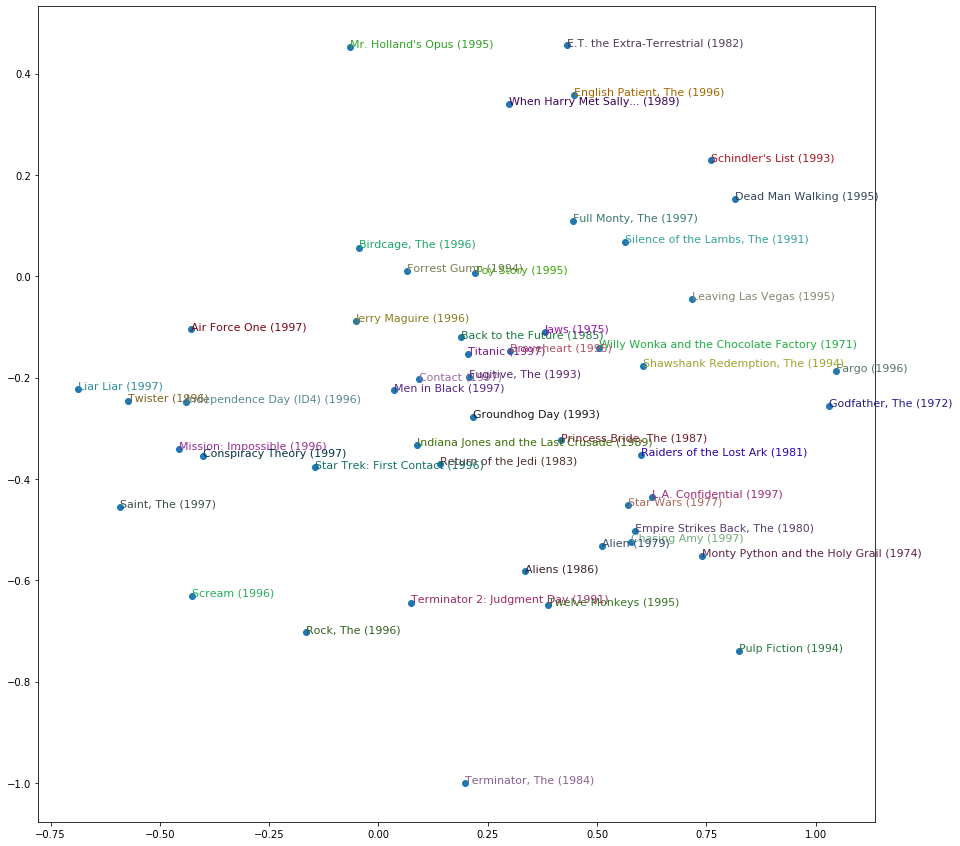

In [23]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()